# **Tercer conjunto de tareas a realizar**

## Paquetes necesarios e inicializaciones

Para la realización de las siguientes tareas, se va a utilizar el mismo *enviroment* de Python llamado VC_P1 creado en el [primer conjunto de tareas](../VC_P1/Exercises_P1.ipynb) y modificado después en el [segundo conjunto de tareas](./VC_P2/Exercises_P2.ipynb), la única dependencia adicional que se ha de descargar es la que viene dada por el paquete **scikit-learn** y **seaborn**.

## TAREA 1

En la primera tarea, el reto o tarea consiste en determinar la cantidad de dinero y monedas presentes en la imagen. Una extensión válida sería la presencia de objetos que no sean monedas en la imagen anañizada.

TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 

In [5]:
import cv2
import numpy as np
import math

# ----------------- Parámetros -----------------
IMG_FILE = "Resources/Monedas.jpg"
IMG_FILE = "Resources/Img1.jpeg"
IMG_FILE = "Resources/Img4.jpeg"

monete_mm = {
    "2€": 25.75, "1€": 23.25, "50c": 24.35, "20c": 22.25,
    "10c": 19.75, "5c": 21.25, "2c": 18.75, "1c": 16.25
}
valori_euro = {"2€":2.0,"1€":1.0,"50c":0.5,"20c":0.2,"10c":0.1,"5c":0.05,"2c":0.02,"1c":0.01}

# clasificación con rango fijo ±0.5 mm
MARGIN_MM = 0.5
coin_ranges = {name: (nominal - MARGIN_MM, nominal + MARGIN_MM) for name, nominal in monete_mm.items()}

# parámetros de filtro
MIN_AREA_PX = 200      # area mínima del contorno considerado
CIRCULARITY_MIN = 0.55 # filtra formas no circulares
SOLIDITY_MIN = 0.6

# umbral de solapamiento para NMS
OVERLAP_THRESH = 0.6

# ----------------- Funciones auxiliares -----------------
def fit_circle_kasa(pts):
    if pts.shape[0] < 3:
        return None
    x = pts[:,0].astype(np.float64)
    y = pts[:,1].astype(np.float64)
    A = np.column_stack([x, y, np.ones_like(x)])
    b = -(x*x + y*y)
    try:
        sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    except np.linalg.LinAlgError:
        return None
    Acoef, Bcoef, Ccoef = sol
    cx = -Acoef/2.0
    cy = -Bcoef/2.0
    rad2 = cx*cx + cy*cy - Ccoef
    if rad2 <= 0 or not np.isfinite(rad2):
        return None
    r = math.sqrt(rad2)
    return float(cx), float(cy), float(r)

def median_radius_from_center(center, contour):
    """Calcula la mediana de las distancias centro->puntos del contorno (más robusto que la media)."""
    cx, cy = center
    pts = contour.reshape(-1,2).astype(np.float64)
    dists = np.hypot(pts[:,0]-cx, pts[:,1]-cy)
    if dists.size == 0:
        return None
    return float(np.median(dists))

def nms_candidates(cands, overlap_thresh=OVERLAP_THRESH):
    """NMS simple: ordena por radio (desc) y elimina centros demasiado cercanos."""
    if not cands:
        return []
    arr = np.array([[c['cx'], c['cy'], c['r']] for c in cands])
    idxs = np.argsort(-arr[:,2])
    keep = []
    for i in idxs:
        xi, yi, ri = arr[i]
        add = True
        for k in keep:
            xk, yk, rk = arr[k]
            if math.hypot(xi-xk, yi-yk) < overlap_thresh*(ri+rk):
                add = False
                break
        if add:
            keep.append(i)
    return [cands[i] for i in keep]

# ----------------- Lectura de la imagen -----------------
img = cv2.imread(IMG_FILE)
if img is None:
    raise SystemExit(f"Imagen no encontrada: {IMG_FILE}")
orig = img.copy()
h, w = img.shape[:2]
print(f"Imagen {IMG_FILE}: {w}x{h}px")

# ----------------- Preprocesado para mejorar bordes -----------------
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# CLAHE para uniformar iluminación
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
gray_cl = clahe.apply(gray)

# filtro bilateral para reducir ruido manteniendo bordes
bil = cv2.bilateralFilter(gray_cl, d=9, sigmaColor=75, sigmaSpace=75)

# ligero desenfoque para estabilizar Canny/Hough
blur = cv2.GaussianBlur(bil, (5,5), 0)

# Canny con umbral automático base (tipo Otsu)
median_val = np.median(blur)
lower = int(max(0, 0.66 * median_val))
upper = int(min(255, 1.33 * median_val))
edges = cv2.Canny(blur, lower, upper)

# threshold adaptativo para obtener regiones "llenas" de las monedas
th_adapt = cv2.adaptiveThreshold(gray_cl, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, 41, 10)

# closing morfológico para cerrar huecos y afinar contornos
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
th_closed = cv2.morphologyEx(th_adapt, cv2.MORPH_CLOSE, kernel, iterations=2)
th_closed = cv2.morphologyEx(th_closed, cv2.MORPH_OPEN, kernel, iterations=1)

# ventanas para ver la aplicacion de los filtres
cv2.imshow("gray_clahe (CLAHE)", gray_cl)
cv2.imshow("blur (Gaussian)", blur)
cv2.imshow("edges (Canny)", edges)
cv2.imshow("th_closed (morphology)", th_closed)
cv2.waitKey(0)
cv2.destroyAllWindows()

# ----------------- Detección de contornos -----------------
contours, _ = cv2.findContours(th_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(f"Contornos encontrados: {len(contours)}")

candidates = []
for c in contours:
    area = cv2.contourArea(c)
    if area < MIN_AREA_PX:
        continue
    perim = cv2.arcLength(c, True)
    if perim <= 0:
        continue
    circ = 4.0 * math.pi * area / (perim * perim)
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull) if len(hull) > 2 else area
    solidity = area / hull_area if hull_area > 0 else 0.0

    if circ < CIRCULARITY_MIN or solidity < SOLIDITY_MIN:
        continue

    # ajuste de círculo con Kasa sobre puntos del contorno
    pts = c.reshape(-1,2).astype(np.float64)
    fit = fit_circle_kasa(pts)
    if fit is None:
        # fallback: minEnclosingCircle
        (cx, cy), r = cv2.minEnclosingCircle(c)
        cx, cy, r = float(cx), float(cy), float(r)
    else:
        cx, cy, r = fit

    # refina r usando la mediana de distancias centro->contorno
    med_r = median_radius_from_center((cx, cy), c)
    if med_r is not None:
        # manten la mediana (más robusta a bordes faltantes) pero limita desviación
        if abs(med_r - r) / (r + 1e-6) < 0.35:
            r = 0.5*(r + med_r)  # promedio entre fit y mediana para robustez
        else:
            r = med_r

    # guarda candidato
    candidates.append({'cx': float(cx), 'cy': float(cy), 'r': float(r),
                       'area': area, 'circ': circ, 'solidity': solidity})

print(f"Candidatos válidos después de filtros: {len(candidates)}")

# ----------------- NMS para remover duplicados -----------------
candidates = nms_candidates(candidates, overlap_thresh=OVERLAP_THRESH)
print(f"Candidatos después de NMS: {len(candidates)}")

# dibuja candidatos numerados para selección
canvas = orig.copy()
for i, c in enumerate(candidates):
    cv2.circle(canvas, (int(round(c['cx'])), int(round(c['cy']))), int(round(c['r'])), (0,255,0), 2)
    cv2.putText(canvas, str(i+1), (int(round(c['cx']))-10, int(round(c['cy']))+10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

# ----------------- Interacción: primer click = moneda 10c de referencia -----------------
pix_per_mm = None
ref_idx = None
clicked = False

def find_candidate_at(xc, yc, candidates):
    for i, c in enumerate(candidates):
        if math.hypot(xc - c['cx'], yc - c['cy']) <= c['r']*1.1:  # tolerancia un poco mayor
            return i
    return None

def on_mouse(event, x, y, flags, param):
    global pix_per_mm, ref_idx, clicked
    if event != cv2.EVENT_LBUTTONDOWN:
        return
    idx = find_candidate_at(x, y, candidates)
    if idx is None:
        print("Clic no sobre candidato: intenta cerca del centro de la moneda.")
        return
    c = candidates[idx]
    diam_px = 2.0 * c['r']
    ref_mm = monete_mm["10c"]   # referencia = 10 céntimos
    pix_per_mm = diam_px / ref_mm
    ref_idx = idx
    clicked = True
    print("\n=== REFERENCIA CONFIGURADA (10 céntimos) ===")
    print(f"Índice candidato: {idx+1}")
    print(f"Diámetro medido: {diam_px:.2f} px")
    print(f"Escala: {pix_per_mm:.6f} px/mm (10c = {ref_mm} mm)")

win = "Selecciona 10c como referencia (click en el número)"
cv2.namedWindow(win, cv2.WINDOW_NORMAL)
cv2.setMouseCallback(win, on_mouse)

print("Pulsa ESC para salir, o haz click en la moneda de 10c (indicada con número).")
while True:
    cv2.imshow(win, canvas)
    k = cv2.waitKey(20) & 0xFF
    if clicked:
        break
    if k == 27:
        print("Salida solicitada por el usuario.")
        cv2.destroyAllWindows()
        raise SystemExit

cv2.destroyAllWindows()

if pix_per_mm is None:
    raise SystemExit("Referencia no configurada; reinicia y haz click en la moneda de 10c.")

# ----------------- Clasificación (rango ±0.5 mm) -----------------
counts = {}
details_px = {}
total_value = 0.0
unknown = []

for c in candidates:
    diam_px = 2.0 * c['r']
    diam_mm = diam_px / pix_per_mm

    # busca las monedas cuyo rango contiene diam_mm
    matches = [name for name, (mn, mx) in coin_ranges.items() if mn <= diam_mm <= mx]
    if len(matches) == 1:
        name = matches[0]
    elif len(matches) > 1:
        name = min(matches, key=lambda n: abs(monete_mm[n] - diam_mm))
    else:
        # fallback: tomo la más cercana y marco posible ambigüedad
        name_closest = min(monete_mm.keys(), key=lambda k: abs(monete_mm[k] - diam_mm))
        if abs(monete_mm[name_closest] - diam_mm) <= 1.0:  # si está dentro de 1mm acepto
            name = name_closest + "*"
        else:
            name = "unknown"
            unknown.append((diam_px, diam_mm))

    counts[name] = counts.get(name, 0) + 1
    details_px.setdefault(name, []).append(diam_px)
    if name in valori_euro:
        total_value += valori_euro[name]

# ----------------- Salida textual solicitada -----------------
print("\nRESULTADO (estimación tras mejor detección de bordes y ajuste):")
# ordena por valor descendente y luego muestra unknown
ordered = [k for k in sorted(monete_mm.keys(), key=lambda k: -valori_euro[k])]
for k in ordered:
    if k in counts:
        print(f"{counts[k]} monedas de {k}, diámetros en píxeles: {', '.join(f'{d:.1f}' for d in details_px[k])}")
# muestra eventuales "*" (fallback) o unknown
others = [k for k in counts.keys() if k not in monete_mm]
for k in others:
    print(f"{counts[k]} monedas de {k}, diámetros en píxeles: {', '.join(f'{d:.1f}' for d in details_px[k])}")

print(f"\nSuma total estimada (sumando solo denominaciones conocidas): {total_value:.2f} €")
if unknown:
    print("\nElementos no clasificados (px, mm):")
    for px, mm in unknown:
        print(f"  {px:.1f} px -> {mm:.2f} mm")

# ----------------- Mostrar imagen final con etiquetas -----------------
out = orig.copy()
for i, c in enumerate(candidates):
    x, y, r = int(round(c['cx'])), int(round(c['cy'])), int(round(c['r']))
    # determina etiqueta usando la misma regla de clasificación para coherencia
    diam_px = 2.0 * c['r']
    diam_mm = diam_px / pix_per_mm
    matches = [name for name, (mn, mx) in coin_ranges.items() if mn <= diam_mm <= mx]
    if len(matches) == 1:
        label = matches[0]
    elif len(matches) > 1:
        label = min(matches, key=lambda n: abs(monete_mm[n] - diam_mm))
    else:
        name_closest = min(monete_mm.keys(), key=lambda k: abs(monete_mm[k] - diam_mm))
        label = name_closest + ("*" if abs(monete_mm[name_closest] - diam_mm) <= 1.0 else "?")
    color = (0,255,0)
    if i == ref_idx:
        color = (255,0,0)
    cv2.circle(out, (x,y), r, color, 2)
    cv2.putText(out, f"{label}", (x-30, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    cv2.putText(out, f"{int(round(diam_px))} px", (x-30, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

cv2.imshow("Resultado - ajuste robusto", out)
cv2.waitKey(0)
cv2.destroyAllWindows()

Imagen Resources/Img4.jpeg: 1536x2048px
Contornos encontrados: 451
Candidatos válidos después de filtros: 44
Candidatos después de NMS: 44
Pulsa ESC para salir, o haz click en la moneda de 10c (indicada con número).

=== REFERENCIA CONFIGURADA (10 céntimos) ===
Índice candidato: 6
Diámetro medido: 216.71 px
Escala: 10.972739 px/mm (10c = 19.75 mm)

RESULTADO (estimación tras mejor detección de bordes y ajuste):
1 monedas de 1€, diámetros en píxeles: 258.7
2 monedas de 20c, diámetros en píxeles: 247.1, 245.7
1 monedas de 10c, diámetros en píxeles: 216.7
1 monedas de 5c, diámetros en píxeles: 229.2
1 monedas de 5c*, diámetros en píxeles: 227.2
38 monedas de unknown, diámetros en píxeles: 34.4, 27.6, 27.5, 27.4, 25.8, 25.5, 25.1, 24.9, 24.6, 23.7, 23.4, 23.2, 23.1, 23.1, 22.7, 22.5, 22.0, 21.2, 21.1, 21.0, 20.9, 20.3, 20.0, 19.8, 19.7, 19.4, 19.1, 18.6, 18.5, 18.3, 18.1, 18.0, 17.9, 17.8, 17.4, 17.2, 16.9, 16.7

Suma total estimada (sumando solo denominaciones conocidas): 1.55 €

Elemento

In [6]:
import cv2
import numpy as np
import math

# ----------------- Parámetros -----------------
IMG_FILE = "Resources/Monedas.jpg"
IMG_FILE = "Resources/Img1.jpeg"
IMG_FILE = "Resources/Img4.jpeg"

monete_mm = {
    "2€": 25.75, "1€": 23.25, "50c": 24.35, "20c": 22.25,
    "10c": 19.75, "5c": 21.25, "2c": 18.75, "1c": 16.25
}
valori_euro = {"2€":2.0,"1€":1.0,"50c":0.5,"20c":0.2,"10c":0.1,"5c":0.05,"2c":0.02,"1c":0.01}

# clasificación con rango fijo ±0.5 mm
MARGIN_MM = 0.5
coin_ranges = {name: (nominal - MARGIN_MM, nominal + MARGIN_MM) for name, nominal in monete_mm.items()}

# parámetros de filtro
MIN_AREA_PX = 200
CIRCULARITY_MIN = 0.55
SOLIDITY_MIN = 0.6
OVERLAP_THRESH = 0.6

# ----------------- Funciones auxiliares -----------------
def fit_circle_kasa(pts):
    if pts.shape[0] < 3:
        return None
    x = pts[:,0].astype(np.float64)
    y = pts[:,1].astype(np.float64)
    A = np.column_stack([x, y, np.ones_like(x)])
    b = -(x*x + y*y)
    try:
        sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    except np.linalg.LinAlgError:
        return None
    Acoef, Bcoef, Ccoef = sol
    cx = -Acoef/2.0
    cy = -Bcoef/2.0
    rad2 = cx*cx + cy*cy - Ccoef
    if rad2 <= 0 or not np.isfinite(rad2):
        return None
    r = math.sqrt(rad2)
    return float(cx), float(cy), float(r)

def median_radius_from_center(center, contour):
    cx, cy = center
    pts = contour.reshape(-1,2).astype(np.float64)
    dists = np.hypot(pts[:,0]-cx, pts[:,1]-cy)
    if dists.size == 0:
        return None
    return float(np.median(dists))

def nms_candidates(cands, overlap_thresh=OVERLAP_THRESH):
    if not cands:
        return []
    arr = np.array([[c['cx'], c['cy'], c['r']] for c in cands])
    idxs = np.argsort(-arr[:,2])
    keep = []
    for i in idxs:
        xi, yi, ri = arr[i]
        add = True
        for k in keep:
            xk, yk, rk = arr[k]
            if math.hypot(xi-xk, yi-yk) < overlap_thresh*(ri+rk):
                add = False
                break
        if add:
            keep.append(i)
    return [cands[i] for i in keep]

# ----------------- Mostrar imágenes más pequeñas -----------------
def show_resized(winname, img, scale=0.4):
    """Muestra una imagen redimensionada para no ocupar toda la pantalla."""
    h, w = img.shape[:2]
    resized = cv2.resize(img, (int(w*scale), int(h*scale)))
    cv2.imshow(winname, resized)

# ----------------- Lectura de la imagen -----------------
img = cv2.imread(IMG_FILE)
if img is None:
    raise SystemExit(f"Imagen no encontrada: {IMG_FILE}")
orig = img.copy()
h, w = img.shape[:2]
print(f"Imagen {IMG_FILE}: {w}x{h}px")

# ----------------- Preprocesado -----------------
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
gray_cl = clahe.apply(gray)
bil = cv2.bilateralFilter(gray_cl, d=9, sigmaColor=75, sigmaSpace=75)
blur = cv2.GaussianBlur(bil, (5,5), 0)
median_val = np.median(blur)
lower = int(max(0, 0.66 * median_val))
upper = int(min(255, 1.33 * median_val))
edges = cv2.Canny(blur, lower, upper)
th_adapt = cv2.adaptiveThreshold(gray_cl, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, 41, 10)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
th_closed = cv2.morphologyEx(th_adapt, cv2.MORPH_CLOSE, kernel, iterations=2)
th_closed = cv2.morphologyEx(th_closed, cv2.MORPH_OPEN, kernel, iterations=1)

# Muestra imágenes reducidas
show_resized("gray_clahe (CLAHE)", gray_cl)
show_resized("blur (Gaussian)", blur)
show_resized("edges (Canny)", edges)
show_resized("th_closed (morphology)", th_closed)
cv2.waitKey(0)
cv2.destroyAllWindows()

# ----------------- Detección de contornos -----------------
contours, _ = cv2.findContours(th_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(f"Contornos encontrados: {len(contours)}")

candidates = []
for c in contours:
    area = cv2.contourArea(c)
    if area < MIN_AREA_PX:
        continue
    perim = cv2.arcLength(c, True)
    if perim <= 0:
        continue
    circ = 4.0 * math.pi * area / (perim * perim)
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull) if len(hull) > 2 else area
    solidity = area / hull_area if hull_area > 0 else 0.0

    if circ < CIRCULARITY_MIN or solidity < SOLIDITY_MIN:
        continue

    pts = c.reshape(-1,2).astype(np.float64)
    fit = fit_circle_kasa(pts)
    if fit is None:
        (cx, cy), r = cv2.minEnclosingCircle(c)
        cx, cy, r = float(cx), float(cy), float(r)
    else:
        cx, cy, r = fit

    med_r = median_radius_from_center((cx, cy), c)
    if med_r is not None:
        if abs(med_r - r) / (r + 1e-6) < 0.35:
            r = 0.5*(r + med_r)
        else:
            r = med_r

    candidates.append({'cx': float(cx), 'cy': float(cy), 'r': float(r),
                       'area': area, 'circ': circ, 'solidity': solidity})

print(f"Candidatos válidos después de filtros: {len(candidates)}")

# ----------------- NMS -----------------
candidates = nms_candidates(candidates, overlap_thresh=OVERLAP_THRESH)
print(f"Candidatos después de NMS: {len(candidates)}")

# ----------------- Mostrar candidatos -----------------
canvas = orig.copy()
for i, c in enumerate(candidates):
    cv2.circle(canvas, (int(round(c['cx'])), int(round(c['cy']))), int(round(c['r'])), (0,255,0), 2)
    cv2.putText(canvas, str(i+1), (int(round(c['cx']))-10, int(round(c['cy']))+10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

# ----------------- Selección de referencia -----------------
pix_per_mm = None
ref_idx = None
clicked = False

def find_candidate_at(xc, yc, candidates):
    for i, c in enumerate(candidates):
        if math.hypot(xc - c['cx'], yc - c['cy']) <= c['r']*1.1:
            return i
    return None

def on_mouse(event, x, y, flags, param):
    global pix_per_mm, ref_idx, clicked
    if event != cv2.EVENT_LBUTTONDOWN:
        return
    idx = find_candidate_at(x, y, candidates)
    if idx is None:
        print("Clic no sobre candidato.")
        return
    c = candidates[idx]
    diam_px = 2.0 * c['r']
    ref_mm = monete_mm["10c"]
    pix_per_mm = diam_px / ref_mm
    ref_idx = idx
    clicked = True
    print(f"\n=== REFERENCIA CONFIGURADA (10 céntimos) ===")
    print(f"Índice candidato: {idx+1}")
    print(f"Diámetro medido: {diam_px:.2f} px")
    print(f"Escala: {pix_per_mm:.6f} px/mm")

win = "Selecciona 10c como referencia"
cv2.namedWindow(win, cv2.WINDOW_NORMAL)
cv2.setMouseCallback(win, on_mouse)

print("Pulsa ESC o haz click en la moneda de 10c.")
while True:
    show_resized(win, canvas, scale=0.5)
    k = cv2.waitKey(20) & 0xFF
    if clicked:
        break
    if k == 27:
        print("Salida solicitada.")
        cv2.destroyAllWindows()
        raise SystemExit

cv2.destroyAllWindows()

if pix_per_mm is None:
    raise SystemExit("Referencia no configurada.")

# ----------------- Clasificación -----------------
counts = {}
details_px = {}
total_value = 0.0
unknown = []

for c in candidates:
    diam_px = 2.0 * c['r']
    diam_mm = diam_px / pix_per_mm
    matches = [name for name, (mn, mx) in coin_ranges.items() if mn <= diam_mm <= mx]
    if len(matches) == 1:
        name = matches[0]
    elif len(matches) > 1:
        name = min(matches, key=lambda n: abs(monete_mm[n] - diam_mm))
    else:
        name_closest = min(monete_mm.keys(), key=lambda k: abs(monete_mm[k] - diam_mm))
        if abs(monete_mm[name_closest] - diam_mm) <= 1.0:
            name = name_closest + "*"
        else:
            name = "unknown"
            unknown.append((diam_px, diam_mm))

    counts[name] = counts.get(name, 0) + 1
    details_px.setdefault(name, []).append(diam_px)
    if name in valori_euro:
        total_value += valori_euro[name]

print("\nRESULTADO:")
ordered = [k for k in sorted(monete_mm.keys(), key=lambda k: -valori_euro[k])]
for k in ordered:
    if k in counts:
        print(f"{counts[k]} monedas de {k}, diámetros: {', '.join(f'{d:.1f}' for d in details_px[k])}")

others = [k for k in counts.keys() if k not in monete_mm]
for k in others:
    print(f"{counts[k]} monedas de {k}, diámetros: {', '.join(f'{d:.1f}' for d in details_px[k])}")

print(f"\nSuma total estimada: {total_value:.2f} €")
if unknown:
    print("\nElementos no clasificados:")
    for px, mm in unknown:
        print(f"  {px:.1f} px -> {mm:.2f} mm")

# ----------------- Mostrar imagen final -----------------
out = orig.copy()
for i, c in enumerate(candidates):
    x, y, r = int(round(c['cx'])), int(round(c['cy'])), int(round(c['r']))
    diam_px = 2.0 * c['r']
    diam_mm = diam_px / pix_per_mm
    matches = [name for name, (mn, mx) in coin_ranges.items() if mn <= diam_mm <= mx]
    if len(matches) == 1:
        label = matches[0]
    elif len(matches) > 1:
        label = min(matches, key=lambda n: abs(monete_mm[n] - diam_mm))
    else:
        name_closest = min(monete_mm.keys(), key=lambda k: abs(monete_mm[k] - diam_mm))
        label = name_closest + ("*" if abs(monete_mm[name_closest] - diam_mm) <= 1.0 else "?")
    color = (255,0,0) if i == ref_idx else (0,255,0)
    cv2.circle(out, (x,y), r, color, 2)
    cv2.putText(out, f"{label}", (x-30, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    cv2.putText(out, f"{int(round(diam_px))} px", (x-30, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

show_resized("Resultado - ajuste robusto", out, scale=0.5)
cv2.waitKey(0)
cv2.destroyAllWindows()


Imagen Resources/Img4.jpeg: 1536x2048px
Contornos encontrados: 451
Candidatos válidos después de filtros: 44
Candidatos después de NMS: 44
Pulsa ESC o haz click en la moneda de 10c.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Clic no sobre candidato.
Salida solicitada.


SystemExit: 

## TAREA 2

Para la segunda tarea, se proporcionan imágenes de tres clases de objetos recogidos en playas canarias: fragmentos plásticos, *pellets* y alquitrán. Para cada categoría se proporciona una imagen completa y una subimagen de la misma. Las dos primeras categorías se consideran microplásticos cuando miden menos de 5mm, mientras que la tercera es muy habitual encontrarlas en playas canarias. Observar que dado que cada imagen contiene muestras de una única categoría, disponen de un conjunto de datos anotado. La tarea propuesta consiste en primer término, hacer uso de las imágenes proporcionadas, extraer de forma automatizada las partículas e identificar patrones en sus características geométricas y de apariencia que puedan permitir la clasificación de las partículas en dichas imágenes. Las características que determinen se usarán para analizar la imagen de test proporcionada, con presencia de muestras de las tres clases. El resultado obtenido debe mostrarse por medio las métricas mostradas en el cuaderno, incluyendo la matriz de confusión, donde se comparan las anotaciones con las predicciones.

![Confusión](../VC_P3/Resources/MatrizConfu.png)  
*Ejemplo de matriz de confusión*

A la hora de considerar posibles características geométricas, como punto de partida para la extracción de descriptores de las partículas, se proporciona enlace al trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498) en el que se adoptan algunas propiedades geométricas para dicho fin. De forma resumida, las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles (A)
- Perímetro en píxeles (P)
- Compacidad (relación del cuadrado del perímetro con el área C=P^2/A)
- Relación del área de la partícula con el área del contenedor que la contiene
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

En relación a la segmentación de las partículas, una probable primera observación es que la aplicación del umbralizado para separarlas del fondo, es delicada. Preprocesamiento como suavizar la imagen de entrada o reducir su tamaño, o aplicar heurísticas basadas en el tamaño mínimo y máximo de los contornos localizados, y la distancia mínima entre ellos, pueden ayudar a filtrar falsas detecciones, pero a pesar de ello, será un desafío obtener una separación perfecta para todas las imágenes con la misma estrategia. Añadir, que la imagen de fragmentos contiene unas 80 partículas, la de *pellets* unas 55 y la de alquitrán unas 54.

Para la realización de la tarea a tratar se van a importar diversas librerias y paquetes necesarios para el tratamiento de las imágenes, para la extracción de características y para el entrenamiento y evaluación de los resultados obtenidos mediante el modelo de clasificación de las partículas.

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.feature import graycomatrix, graycoprops
from pathlib import Path

Con las importaciones terminadas, lo primero a realizar es cargar en una variable un diccionario en donde la clave es cada uno de los objetos a encontrar en la imagen y sus valores son las imágenes dadas desde el principio para el entrenamiento del test.

Para amplicar la cantidad de imágenes de test de manera virtual, se crea una carpeta dentro de la ruta **../VC_P3/Resources/Task2** llamada **Augmented** en donde mediante una función llamada __*generate_images*__ en donde se rota la imagen pasada por parámetro y se devuelve en una lista junto con la original.

In [3]:
# ============================================================
# 1️⃣ RUTAS DE IMÁGENES
# ============================================================
image_paths = {
    "FRA": [
        "../VC_P3/Resources/Task2/FRA.png",
        "../VC_P3/Resources/Task2/fragment-03-olympus-10-01-2020.JPG"
    ],
    "PEL": [
        "../VC_P3/Resources/Task2/PEL.png",
        "../VC_P3/Resources/Task2/pellet-03-olympus-10-01-2020.JPG"
    ],
    "TAR": [
        "../VC_P3/Resources/Task2/TAR.png",
        "../VC_P3/Resources/Task2/tar-03-olympus-10-01-2020.JPG"
    ]
}

output_dir = "../VC_P3/Resources/Task2/Augmented/"
Path(output_dir).mkdir(parents=True, exist_ok=True)

# ============================================================
# 2️⃣ AUMENTACIÓN DE IMÁGENES (manteniendo color)
# ============================================================
def generate_images(image):
    # Solo original y flips mínimos si quieres
    more = [image, cv2.flip(image, 1)]
    return more

Tras lo anterior, se crean las imágenes mencionadas mediante un bucle (2 imágenes más por tipo) y, en caso de estar ya creadas las imágenes, se "machacan" para crear otras nuevas (esto es muy útil para los siguientes modelos que usan otras imágenes).

In [4]:
# Generar imágenes aumentadas
for label, paths in image_paths.items():
    index = 0
    for path in paths:
        image = cv2.imread(path)
        if image is None:
            continue
        aug_images = generate_images(image)
        for i, img in enumerate(aug_images):
            out_path = Path(output_dir) / f"{label}_{index*4+i+1}.png"
            if out_path.exists():
                print(f"⚠️ Sobrescribiendo {out_path}")
            cv2.imwrite(str(out_path), img)  # Sobrescribe automáticamente
        index += 1

print("✅ Imágenes generadas y guardadas en", output_dir)

⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\FRA_1.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\FRA_2.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\FRA_5.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\FRA_6.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\PEL_1.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\PEL_2.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\PEL_5.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\PEL_6.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\TAR_1.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\TAR_2.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\TAR_5.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\TAR_6.png
✅ Imágenes generadas y guardadas en ../VC_P3/Resources/Task2/Augmented/


Para el extractor de características se ha decidido tomar el área y perímetro de los objetos convirtiendo antes la imagen a escala de grises y evaluandola en dos función, el método llamado __*area_calculator*__ y __*perimeter_calculator*__ y tras esto, se pasa a una función llamada __*extract_features*__ la cual tiene el trabajo de juntar la información recibida por los métodos anteriores y clasificar los parámetros para evaluar los objetos en las imágenes.

**QUITAR RESTRICCIONES EN LA EXTRACCIÓN DE CARACTERÍSTICAS.**

✅ Imágenes de entrenamiento generadas y guardadas en ../VC_P3/Resources/Task2/Augmented/
---------------------------------------------------------------------------
🔹 Accuracy (Clasificación basada en Reglas, ÚLTIMO AJUSTE LÓGICO): 71.13%

Matriz de confusión:
     FRA  PEL  TAR
FRA   45    1    3
PEL   21   13    0
TAR    2    1   11

==================== DATAFRAME DE PREDICCIONES (Muestra) ====================
 Index_ROI True_Label Pred_Label  Mean_Val_HSV  Circularity_Weighted
         0        TAR        TAR       171.986                 0.000
         1        TAR        TAR       141.519                 0.783
         2        TAR        TAR       136.651                 0.746
         3        TAR        TAR       180.004                 0.739
         4        TAR        PEL       202.824                 0.807
         5        TAR        FRA       208.616                 0.465
         6        TAR        TAR       169.361                 0.767
         7        TAR        TAR

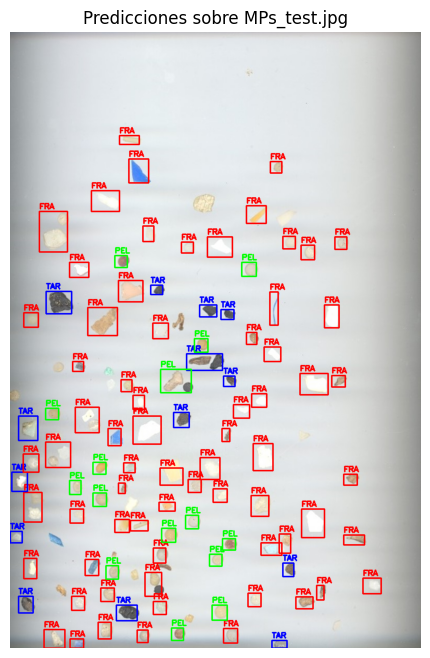

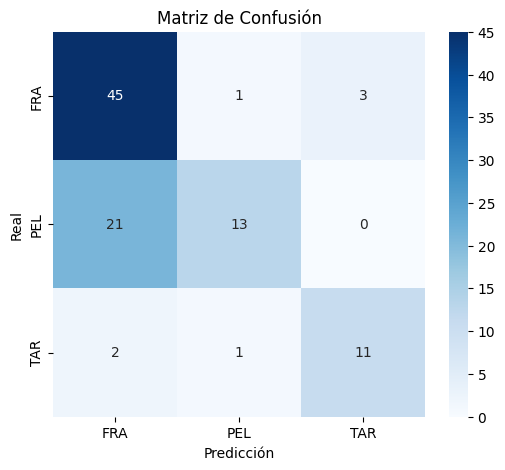

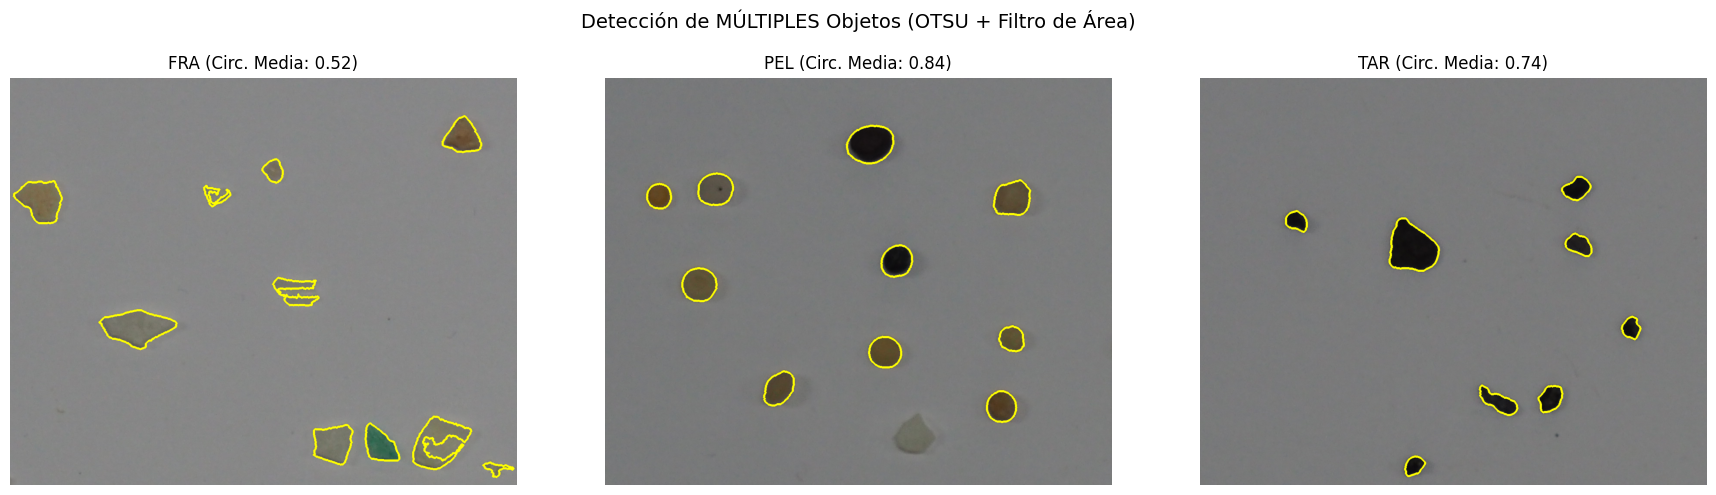

In [61]:
import cv2
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
import math

warnings.filterwarnings('ignore')

# ============================================================
# 0️⃣ AUMENTACIÓN DE IMÁGENES (PRE-PROCESO)
# ============================================================
image_paths = {
    "FRA": [
        "../VC_P3/Resources/Task2/FRA.png",
        "../VC_P3/Resources/Task2/fragment-03-olympus-10-01-2020.JPG"
    ],
    "PEL": [
        "../VC_P3/Resources/Task2/PEL.png",
        "../VC_P3/Resources/Task2/pellet-03-olympus-10-01-2020.JPG"
    ],
    "TAR": [
        "../VC_P3/Resources/Task2/TAR.png",
        "../VC_P3/Resources/Task2/tar-03-olympus-10-01-2020.JPG"
    ]
}

output_dir = "../VC_P3/Resources/Task2/Augmented/"
Path(output_dir).mkdir(parents=True, exist_ok=True)

def generate_images(image):
    more = [image, cv2.flip(image, 1)]
    return more

# Generar imágenes aumentadas
for label, paths in image_paths.items():
    index = 0
    for path in paths:
        full_path = Path(path)
        if not full_path.exists():
            continue
            
        image = cv2.imread(str(full_path))
        if image is None:
            continue
            
        aug_images = generate_images(image)
        
        for i, img in enumerate(aug_images):
            out_path = Path(output_dir) / f"{label}_{index*4+i+1}.png"
            cv2.imwrite(str(out_path), img)
        
        index += 1

print("✅ Imágenes de entrenamiento generadas y guardadas en", output_dir)
print("-" * 75)

# ============================================================
# 1️⃣ RUTAS DE ENTRADA PARA EVALUACIÓN
# ============================================================
test_image_path = "../VC_P3/Resources/Task2/MPs_test.jpg"
test_csv_path = "../VC_P3/Resources/Task2/MPs_test_bbs.csv"

# ============================================================
# 2️⃣ EXTRACCIÓN DE CARACTERÍSTICAS
# ============================================================
def extract_features(image):
    """
    Segmenta todos los objetos usando OTSU, filtra por área y calcula
    la Circularidad Media Ponderada y el Mean_Val.
    """
    if image is None or image.size == 0:
        return 0, 0, []
        
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_val = np.mean(hsv[:, :, 2])

    # Segmentación: Binarización con OTSU
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    total_weighted_circularity = 0
    total_area = 0
    valid_contours = []
    min_area_thresh = 100 # Filtro de área mínimo

    for c in contours:
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        
        if area > min_area_thresh:
            valid_contours.append(c)
            total_area += area
            
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter ** 2)
                total_weighted_circularity += circularity * area
    
    if total_area > 0:
        mean_weighted_circularity = total_weighted_circularity / total_area
    else:
        mean_weighted_circularity = 0
            
    return mean_val, mean_weighted_circularity, valid_contours

# ============================================================
# 3️⃣ CLASIFICADOR BASADO EN REGLAS (AJUSTE FINAL: Comprobación Dual)
# ============================================================
def predict_rules(image, circ_thresh=0.785, val_thresh=182.5): 
    # Usamos circ_thresh=0.75 y val_thresh=190
    mean_val, circularity, _ = extract_features(image)
    
    # 🟢 Regla 1 (Forma): PEL (Circularidad alta) - Atrapa PEL claros y oscuros por forma.
    if circularity > circ_thresh: 
        return "PEL"
    
    # 🔵 Regla 2 (Color): FRA (Fragmento Plástico) - Si no es circular, ¿es muy brillante?
    elif mean_val <= val_thresh: 
        return "TAR"
    
    # 🔴 Regla 3 (Residual): TAR (Alquitrán) - Es lo que queda: ni circular ni brillante.
    else:
        return "FRA"

# ============================================================
# 4️⃣ EVALUACIÓN SOBRE LA IMAGEN DE TEST Y CAPTURA DE DATAFRAME
# ============================================================
if not Path(test_image_path).exists() or not Path(test_csv_path).exists():
    print(f"\n❌ Error: Asegúrate de que los archivos de prueba existen en las rutas especificadas.")
    exit() 

test_img = cv2.imread(test_image_path)
bbs = pd.read_csv(test_csv_path)

y_true, y_pred = [], []
df_data = []

for idx, row in bbs.iterrows():
    x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
    label = row['label'].strip().upper()

    y1, y2 = max(0, y1), min(test_img.shape[0], y2)
    x1, x2 = max(0, x1), min(test_img.shape[1], x2)

    roi = test_img[y1:y2, x1:x2]
    if roi.size == 0 or roi.shape[0] <= 1 or roi.shape[1] <= 1:
        continue

    mean_val, circularity, _ = extract_features(roi)
    pred = predict_rules(roi)
    
    y_true.append(label)
    y_pred.append(pred)
    
    df_data.append({
        'Index_ROI': idx,
        'True_Label': label,
        'Pred_Label': pred,
        'Mean_Val_HSV': mean_val,
        'Circularity_Weighted': circularity
    })

# ============================================================
# 5️⃣ RESULTADOS, DATAFRAME Y VISUALIZACIÓN
# ============================================================
target_labels = ["FRA", "PEL", "TAR"]
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred, labels=target_labels)
results_df = pd.DataFrame(df_data)

print(f"🔹 Accuracy (Clasificación basada en Reglas, ÚLTIMO AJUSTE LÓGICO): {acc*100:.2f}%")
print("\nMatriz de confusión:")
print(pd.DataFrame(cm, index=target_labels, columns=target_labels))

# ---
## 5.1 DataFrame de Resultados 📊
print("\n" + "="*20 + " DATAFRAME DE PREDICCIONES (Muestra) " + "="*20)
print(results_df.head(10).to_string(index=False, float_format="%.3f"))
print("="*75)
# ---

# Visualización con cajas de colores
color_map = {"FRA": (0, 0, 255), "PEL": (0, 255, 0), "TAR": (255, 0, 0)} # BGR
vis_img = test_img.copy()

for i, row in bbs.iterrows():
    if i >= len(y_pred):
        continue
    x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
    
    x1, y1, x2, y2 = max(0, x1), max(0, y1), min(vis_img.shape[1], x2), min(vis_img.shape[0], y2)
    
    label_pred = y_pred[i]
    color = color_map.get(label_pred, (255, 255, 255))
    cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(vis_img, label_pred, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title("Predicciones sobre MPs_test.jpg")
plt.axis("off")
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# ---
## 5.2 Visualización de Objetos Detectados (Entrenamiento) 🖼️
fig, axes = plt.subplots(1, len(image_paths), figsize=(18, 5))
fig.suptitle("Detección de MÚLTIPLES Objetos (OTSU + Filtro de Área)", fontsize=14)

for i, (label, paths) in enumerate(image_paths.items()):
    path = paths[0]
    full_path = Path(path)
    
    if full_path.exists():
        img = cv2.imread(str(full_path))
        if img is not None:
            mean_val, circularity, valid_contours = extract_features(img)
            
            vis_img = img.copy()
            
            if valid_contours:
                cv2.drawContours(vis_img, valid_contours, -1, (0, 255, 255), 3) # Cyan/Amarillo
                
            vis_img_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
            
            axes[i].imshow(vis_img_rgb)
            axes[i].set_title(f"{label} (Circ. Media: {circularity:.2f})")
            axes[i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()